## OBJECTIVE : 

### To identify if tweets are about disaster or not (Kaggle Competition)

In [1]:
import warnings
warnings.simplefilter("ignore")

In [38]:
import os
import sys
import ipdb
import numpy as np
import pandas as pd
import spacy
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.tokenize import sent_tokenize, word_tokenize

print("Numpy Version : ", np.__version__)
print("Pandas Version : ", pd.__version__)

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

print("Matplotlib Version : ", mpl.__version__)

Numpy Version :  1.18.1
Pandas Version :  1.0.1
Matplotlib Version :  3.1.3


In [3]:
# Initializing spacy model
nlp = spacy.load('en_core_web_md')

In [4]:
DATA_DIR = "../data/"
OBJECT_DIR = "../objects/"
LOG_DIR = "../logs/"

In [5]:
LUCKY_SEED = 42

In [6]:
ORIG_DATA_DIR = os.path.join(DATA_DIR, "orig_data/nlp-getting-started")
TRAIN_DIR = os.path.join(DATA_DIR, "training_data")
VALID_DIR = os.path.join(DATA_DIR, "validation_data")
TEST_DIR = os.path.join(DATA_DIR, "testing_data")

In [7]:
KEEPWORDS = ['up', 'down', 'no', 'not', 'nothing', 'none', 'neither', 'never', 'except', 'below', 'bottom', 'without', 'serious', \
            'really', 'above', 'against', 'cannot', 'least', 'less', 'more', 'most', 'must', 'top', 'well']
for word in KEEPWORDS:
    nlp.Defaults.stop_words.remove(word)
STOPWORDS = list(STOPWORDS) + list(nlp.Defaults.stop_words)
DATE_STOPWORDS = ['january', 'february', 'march', 'april', 'may', 'june', \
                  'july', 'august', 'september', 'october', 'november', 'december', \
                 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday', \
                 'today', 'tomorrow', 'yesterday', 'year', 'month', 'date', 'day']
NUM_STOPWORDS = ['hundred', 'hundreds', 'thousand', 'thousands', 'million', 'millions', 'billion', 'billions']
REL_STOPWORDS = ['brother', 'sister', 'son', 'daughter', 'father', 'mother', 'uncle', 'aunt', 'aunty', 'wife', \
                 'husband', 'cousin', 'nephew', 'niece', 'child', 'dad', 'mom', 'papa', 'mummy', 'bro', 'sis', \
                 'grandfather', 'grandmother', 'granny', 'grandpa', 'grandma', 'children', 'boy', 'boys', 'guy', \
                 'guys', 'girl', 'girls', 'man', 'men', 'woman', 'women']
DIR_STOPWORDS = ['north', 'south', 'east', 'west']
STOPWORDS += DATE_STOPWORDS + NUM_STOPWORDS + REL_STOPWORDS + DIR_STOPWORDS
STOPWORDS = set(STOPWORDS)
print(len(STOPWORDS))

445


In [8]:
# Read data
data = pd.read_csv(os.path.join(ORIG_DATA_DIR, "train.csv"))

In [9]:
print("Shape of data : ", data.shape)

Shape of data :  (7613, 5)


In [10]:
print("Features : ", data.columns.values)

Features :  ['id' 'keyword' 'location' 'text' 'target']


In [11]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [12]:
print("Counts of different Targets : ")
data["target"].value_counts()

Counts of different Targets : 


0    4342
1    3271
Name: target, dtype: int64

In [13]:
print("Dataframe Information : ")
data.info()

Dataframe Information : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [14]:
print("Count of null values in text column : {}".format(data["text"].isnull().sum()))

Count of null values in text column : 0


In [15]:
print("Count of null values in target column : {}".format(data["target"].isnull().sum()))

Count of null values in target column : 0


In [16]:
# Read test data
test_data = pd.read_csv(os.path.join(ORIG_DATA_DIR, "test.csv"))

In [17]:
print("Shape of test data : {}".format(test_data.shape))

Shape of test data : (3263, 4)


In [18]:
print("Features in test data : {}".format(test_data.columns.values))

Features in test data : ['id' 'keyword' 'location' 'text']


In [19]:
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [20]:
print("Test Dataframe Information : ")
test_data.info()

Test Dataframe Information : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


#### Analysis of training data

In [21]:
data.drop_duplicates(subset="text").shape, data.shape, data.drop_duplicates().shape

((7503, 5), (7613, 5), (7613, 5))

In [22]:
data[data["text"].duplicated()][["text", "target"]]

,text,target
48,Check these out: http://t.co/rOI2NSmEJJ http:/...,0
115,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...,0
119,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/TH...,0
164,Experts in France begin examining airplane deb...,1
624,To fight bioterrorism sir.,0
...,...,...
7600,Evacuation order lifted for town of Roosevelt:...,1
7607,#stormchase Violent Record Breaking EF-5 El Re...,1
7609,@aria_ahrary @TheTawniest The out of control w...,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1


In [23]:
## There are text with same content but with different target labels; so dropping duplicates based on text field

In [24]:
data = data.drop_duplicates(subset="text").reset_index(drop=True)

In [25]:
data.shape

(7503, 5)

In [26]:
data["target"].value_counts()

0    4305
1    3198
Name: target, dtype: int64

In [27]:
data["lcased_text"] = data["text"].map(lambda x:x.lower())

In [36]:
def create_wordcloud(sentences, label):
    print("Target Type : ", label)
    fig_dims = (20, 12)
    text = ' '.join(sentences) 
    wordcloud = WordCloud(stopwords=STOPWORDS, max_words=200, background_color="white").generate(text)
    fig, ax = plt.subplots(figsize=fig_dims)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
def get_word_count(text):
    word_count = 0
    sentences = sent_tokenize(text)
    for sen in sentences:
        word_count += len(word_tokenize(sen))
    return word_count

In [39]:
data["word_count"] = data["lcased_text"].map(get_word_count)

Target Type :  Non Disaster Tweets


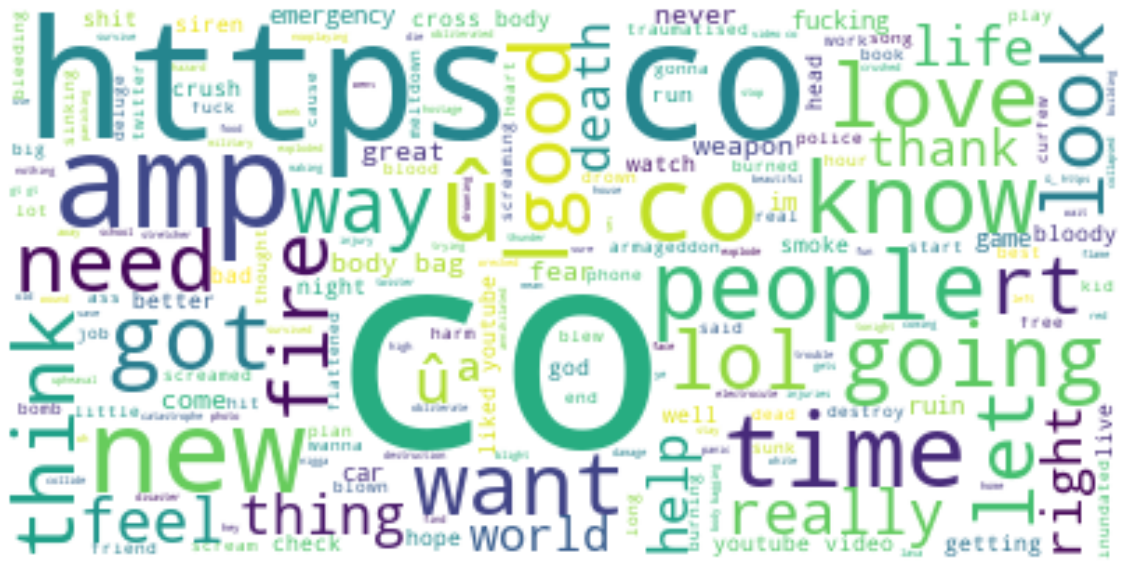

In [34]:
create_wordcloud(data.loc[data["target"]==0, "lcased_text"].values, "Non Disaster Tweets")

Target Type :  Disaster Tweets


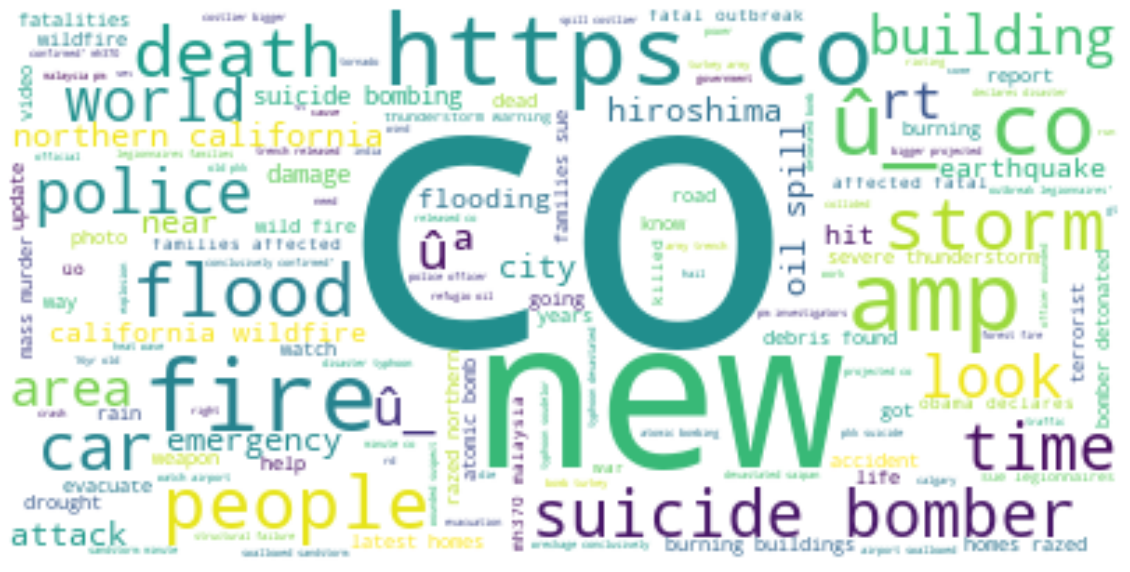

In [35]:
create_wordcloud(data.loc[data["target"]==1, "lcased_text"].values, "Disaster Tweets")

In [61]:
def word_count_analysis(data, label):
    print('Word Count for Target : ', label)
    print(data.describe())
    fig_dims = (16, 7)
    fig, ax = plt.subplots(figsize=fig_dims)
    y = data.values
    x = list(range(y.size))
    sns.lineplot(x, y, label=label)
    plt.grid()
    plt.xlabel('<--- Tweets --->')
    plt.ylabel('<--- Word Counts --->')
    plt.show()

Word Count for Target :  Non Disaster Tweets
count    4305.000000
mean       18.602091
std         7.434806
min         1.000000
25%        13.000000
50%        19.000000
75%        24.000000
max        72.000000
Name: word_count, dtype: float64


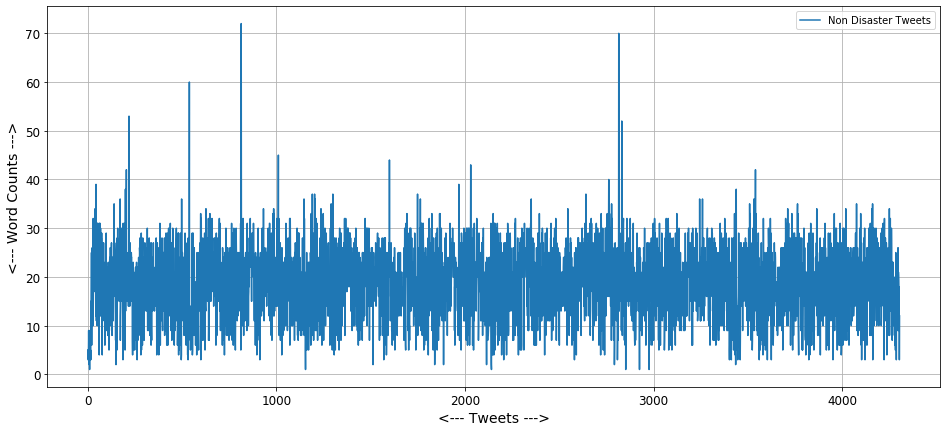

In [62]:
word_count_analysis(data.loc[data["target"]==0, "word_count"], "Non Disaster Tweets")

Word Count for Target :  Disaster Tweets
count    3198.000000
mean       19.201689
std         6.026656
min         2.000000
25%        15.000000
50%        20.000000
75%        24.000000
max        39.000000
Name: word_count, dtype: float64


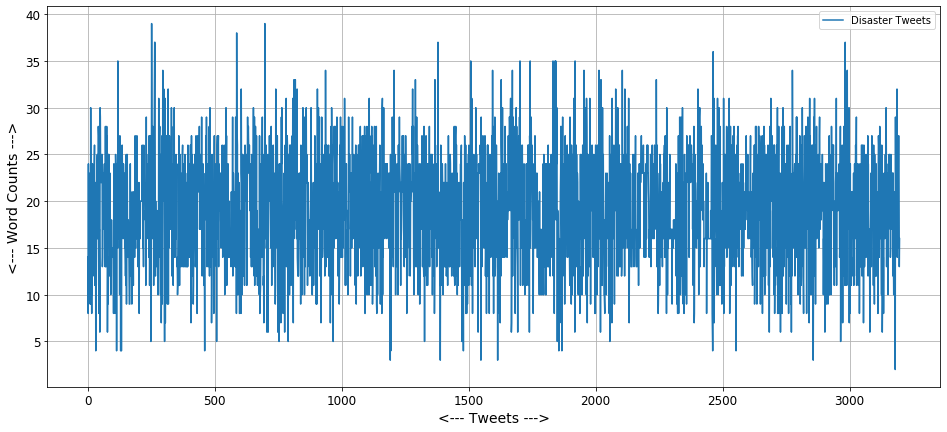

In [63]:
word_count_analysis(data.loc[data["target"]==1, "word_count"], "Disaster Tweets")